En este problema se usan las funciones definidad en la parte 1 para implementar MCMC con el algoritmo Metropolis-Hastings y visualizar problemas de convergencia

---------

La gran mayoría de funciones que cree las dejé en el archivo Mis_funciones.py para hacer más fácil de leer esta hoja

In [3]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
from Misfunciones import *
import pandas
# Estilo de gráficos
plt.style.use('dark_background')
# Seed
np.random.seed(123)

In [4]:
plt.style.use('dark_background')
Datos = pandas.read_csv('blanton.csv', sep=',')
# Pongo los datos en dos variables
Mags = Datos['M']
Lum = Datos['f']
Barra_sup = np.loadtxt('Barra_sup.txt')
Barra_inf = np.loadtxt('Barra_inf.txt')

ERR = []
ij = 0
while ij<len(Barra_sup):
    ERR.append( (1/2.) * (Barra_sup[ij] - Barra_inf[ij]) )
    ij = ij + 1

In [5]:
# Modelo Blanton
xs = np.linspace(min(Mags), max(Mags), 100)
F_mod = Modelo(xs,1.46e-2, -20.83, -1.2)

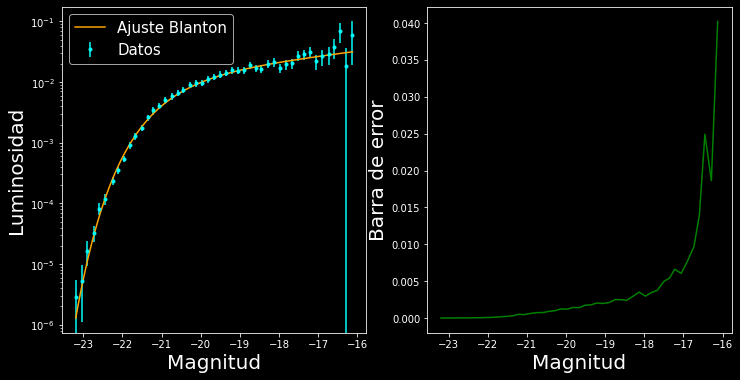

In [6]:
fig, ax = plt.subplots(1, 2, figsize = (12,6), sharex=True)

ax[0].plot(xs, F_mod, color='orange', label='Ajuste Blanton')
ax[0].errorbar(Mags, Lum, yerr=ERR, color='cyan', fmt='.', label='Datos')

ax[1].plot(Mags, ERR, color='green')

ax[0].set_xlabel('Magnitud', fontsize=20)
ax[0].set_ylabel('Luminosidad', fontsize=20)
ax[1].set_xlabel('Magnitud', fontsize=20)
ax[1].set_ylabel('Barra de error', fontsize=20)
ax[0].set_yscale('log')
ax[0].legend(fontsize=15, loc=2);

In [7]:
# Para ver los límites de los PRIORS pruebo algunos valores de los parámetros:
Phi_inf = Modelo(xs, 0.46e-2, -20.83, -1.2)
Phi_sup = Modelo(xs, 10.46e-2, -20.83, -1.2)

Me_inf = Modelo(xs, 1.46e-2, -25.83, -1.2)
Me_sup = Modelo(xs, 1.46e-2, -19.93, -1.2)

alpha_inf = Modelo(xs, 1.46e-2, -20.83, -1.5)
alpha_sup = Modelo(xs, 1.46e-2, -20.83, -0.9)

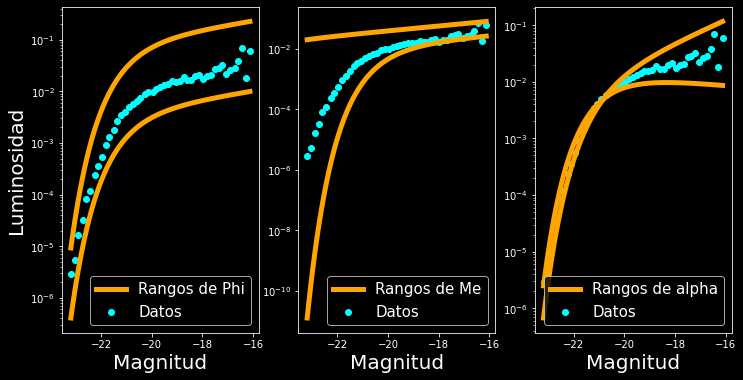

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (12,6), sharex=True)

ax[0].scatter(Mags, Lum, color='cyan', label='Datos')
ax[0].plot(xs, Phi_inf, color='orange', label='Rangos de Phi', lw=5)
ax[0].plot(xs, Phi_sup, color='orange', lw=5)

ax[1].scatter(Mags, Lum, color='cyan', label='Datos')
ax[1].plot(xs, Me_inf, color='orange', label='Rangos de Me', lw=5)
ax[1].plot(xs, Me_sup, color='orange', lw=5)

ax[2].scatter(Mags, Lum, color='cyan', label='Datos')
ax[2].plot(xs, alpha_inf, color='orange', label='Rangos de alpha', lw=5)
ax[2].plot(xs, alpha_sup, color='orange', lw=5)

ax[0].set_xlabel('Magnitud', fontsize=20)
ax[1].set_xlabel('Magnitud', fontsize=20)
ax[2].set_xlabel('Magnitud', fontsize=20)
ax[0].set_ylabel('Luminosidad', fontsize=20)
ax[0].set_yscale('log')
ax[0].legend(fontsize=15)
ax[1].set_yscale('log')
ax[1].legend(fontsize=15)
ax[2].set_yscale('log')
ax[2].legend(fontsize=15);

In [9]:
# Los límites quedaron:
rPhi = [0.46e-2, 10.46e-2]
rMe = [-25.83, -19.93]
ralpha = [-1.5, -0.9]

## Metropolis- Hastings, definiciones

Mi PROPOSAL será una gaussiana centrada en cero con desviación estándar 'std'. Esta desviación me determina qué tan grande (o largo) pueden ser los pasos en las cadenas

---------

Mi PRIOR será una distribución uniforme en 3d, está limitado adentro de la definición de la función CADENAS() que viene a continuación. 

In [10]:
def CADENAS(Nsteps, Nburnt, Tstep, rPhi, rMe, ralpha):
    """ Devuelve las cadenas de Markov para los tres parámetros del problema
    
    Parameters
    ----------
    Nsteps : int
        Número de pasos de las cadenas
    Nburnt : int
        Número de pasos desde que se empiezan a grabar las cadenas (quemado)
    Tstep : .float
        Una medida del tamaño de los pasos de las cadenas
    rPhi, rMe, ralpha : list(2x1), list(2x1), list(2x1)
        Rangos para el PRIOR, asociados a los parámetros. Ejemplo: rPhi = [0,1]
    
    Returns
    -------
    Cadenas : list
        Lista con los pasos y la evolución de los parámetros
        (Paso, Phi_evol, Me_evol, alpha_evol)
    """
    import numpy as np
    Paso = [] # Graba los pasos
    Phi_evol = [] # Cadenas para el parámetro "Phi"
    Me_evol = []
    alpha_evol = []

    # Busco condición inicial tal que la posterior no sea cero
    post_actual = 0
    while post_actual < 1e-8:
        phi_actual = np.random.normal(loc=np.mean([rPhi[0], rPhi[1]]),
                                      scale=(rPhi[1]-rPhi[0]))
        Me_actual = np.random.normal(loc=np.mean([rMe[0], rMe[1]]),
                                     scale=(rMe[1]-rMe[0]))
        alpha_actual = np.random.normal(loc=np.mean([ralpha[0], ralpha[1]]),
                                        scale=(ralpha[1]-ralpha[0]))
        
        post_actual = POSTERIOR(Mags, Lum, ERR, 
                                Phi=phi_actual, Me=Me_actual, alpha=alpha_actual,
                                Phimin=rPhi[0], Phimax=rPhi[1],
                                Memin=rMe[0], Memax=rMe[1], 
                                alphamin=ralpha[0], alphamax=ralpha[1] )
    
    par_actual = [phi_actual, Me_actual, alpha_actual]
    ij = 0
    while ij<Nsteps:
        # Posterior de los parámetros actuales:
        post_actual = POSTERIOR(Mags, Lum, ERR, 
                                Phi=par_actual[0], Me=par_actual[1], alpha=par_actual[2],
                                Phimin=rPhi[0], Phimax=rPhi[1],
                                Memin=rMe[0], Memax=rMe[1], 
                                alphamin=ralpha[0], alphamax=ralpha[1] )

        # El nuevo lugar será el anterior más un desplazamiento en todas las direciones
        # que obedece a unos sorteos gaussianos, para cada variable tengo una longitud
        # de paso distinta
        
        Saltos = np.random.normal(loc=0, scale=Tstep, size=3)
        pc0 = par_actual[0] + 0.001*Saltos[0]
        pc1 = par_actual[1] + 0.01*Saltos[1]
        pc2 = par_actual[2] + 0.005*Saltos[2]
        par_candid = np.array( [pc0, pc1, pc2] )
        
        # Veo la nueva posterior
        post_candid = POSTERIOR(Mags, Lum, ERR, 
                                Phi=par_candid[0], Me=par_candid[1], alpha=par_candid[2],
                                Phimin=rPhi[0], Phimax=rPhi[1],
                                Memin=rMe[0], Memax=rMe[1], 
                                alphamin=ralpha[0], alphamax=ralpha[1] )
        
        # Probabilidad de aceptación:
        p_accept = min(1., post_candid / post_actual)
        # Condición de aceptación:
        accept = np.random.rand() < p_accept
    
        if accept==True:
            par_actual = par_candid
        else:
            par_actual = par_actual
            
        # Solo guardo los pasos que hallan superado al quemado:
        if ij>Nburnt:
            Paso.append( ij )
            Phi_evol.append( par_actual[0] )
            Me_evol.append( par_actual[1] )
            alpha_evol.append( par_actual[2] )
            
        # Imprime progreso:
        from IPython.display import clear_output
        clear_output(wait=True)
        print('%', round(ij*100/Nsteps))

        ij = ij + 1
    return Paso, Phi_evol, Me_evol, alpha_evol

### Acá pondré unos bloques para crear las cadenas, y luego unos para guardar datos y otro para cargarlos

Uno puedo correr las cadenas y luego ir directamente a la parte de ploteos o, sino, puede ignorar las cadenas e ir directamente a la parte de importación de los archivos que las contienen (recomendado)

In [13]:
# Datos para hacer las cadenas:
Nburnt = 0
Nsteps = 50000

In [13]:
# Haré cadenas cambiando sólo la longitud de los pasos "Tstep"
# C = CADENAS(Nsteps=Nsteps, Nburnt=Nburnt, Tstep=1, rPhi=rPhi, rMe=rMe, ralpha=ralpha)

% 100


In [28]:
# C2 = CADENAS(Nsteps=Nsteps, Nburnt=Nburnt, Tstep=1, rPhi=rPhi, rMe=rMe, ralpha=ralpha)

% 100


In [32]:
# C3 = CADENAS(Nsteps=Nsteps, Nburnt=Nburnt, Tstep=1, rPhi=rPhi, rMe=rMe, ralpha=ralpha)

% 100


In [14]:
# C4 = CADENAS(Nsteps=Nsteps, Nburnt=Nburnt, Tstep=0.1, rPhi=rPhi, rMe=rMe, ralpha=ralpha)

% 100


In [19]:
# C5 = CADENAS(Nsteps=Nsteps, Nburnt=Nburnt, Tstep=10, rPhi=rPhi, rMe=rMe, ralpha=ralpha)

% 100


### Guardado de datos (manual):

In [20]:
# Save_chain(Steps=C5[0], Phi=C5[1], Me=C5[2], alpha=C5[3], name='Cadena5.txt')

### Importación de datos:

In [12]:
D = np.loadtxt('Cadena.txt')
C = [D[:,0], D[:,1], D[:,2], D[:,3] ]

D2 = np.loadtxt('Cadena2.txt')
C2 = [D2[:,0], D2[:,1], D2[:,2], D2[:,3] ]

D3 = np.loadtxt('Cadena3.txt')
C3 = [D3[:,0], D3[:,1], D3[:,2], D3[:,3] ]

D4 = np.loadtxt('Cadena4.txt')
C4 = [D4[:,0], D4[:,1], D4[:,2], D4[:,3] ]

D5 = np.loadtxt('Cadena5.txt')
C5 = [D5[:,0], D5[:,1], D5[:,2], D5[:,3] ]

Para hacer los ploteos cree la función $\color{orange}{\text{Ploteo()}}$

Convenientemente, hice que las primeras tres cadenas tengan un buen mezclado (mucha prueba y error) y las otras dos tienen pasos muy chicos o grandes.

Las grafico por separado para que se vean mejor:
(La línea celeste por detrás es el valor de Blanton)

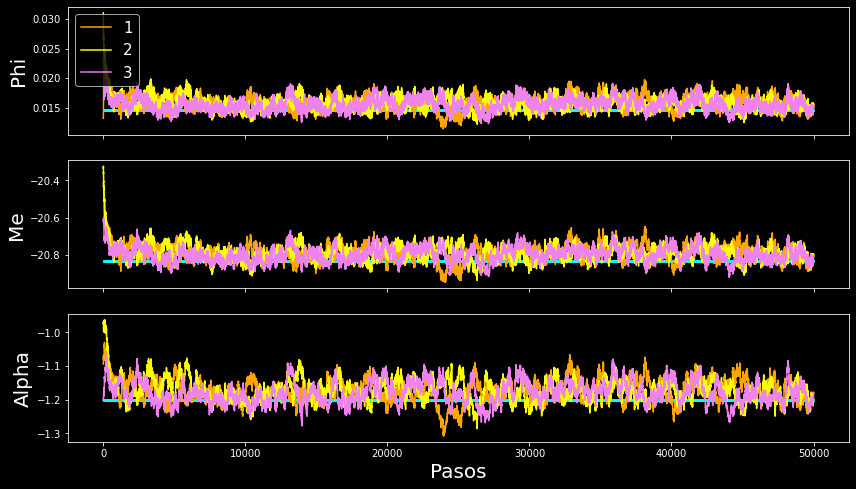

In [14]:
""" BUEN MEZCLADO (SIN QUEMADO) """
fig, ax = plt.subplots(3, 1, figsize = (14,8), sharex=True)
Ploteo(C, color='orange', label='1', fig=fig, ax=ax)
Ploteo(C2, color='yellow', label='2', fig=fig, ax=ax)
Ploteo(C3, color='violet', label='3', fig=fig, ax=ax)
# Bordes de los priors
# ax[0].fill_between([Nburnt, Nsteps], y1=rPhi[0], y2=rPhi[1], facecolor='green', alpha=0.3)
# ax[1].fill_between([Nburnt, Nsteps], y1=rMe[0], y2=rMe[1], facecolor='green', alpha=0.3)
# ax[2].fill_between([Nburnt, Nsteps], y1=ralpha[0], y2=ralpha[1], facecolor='green', alpha=0.3)

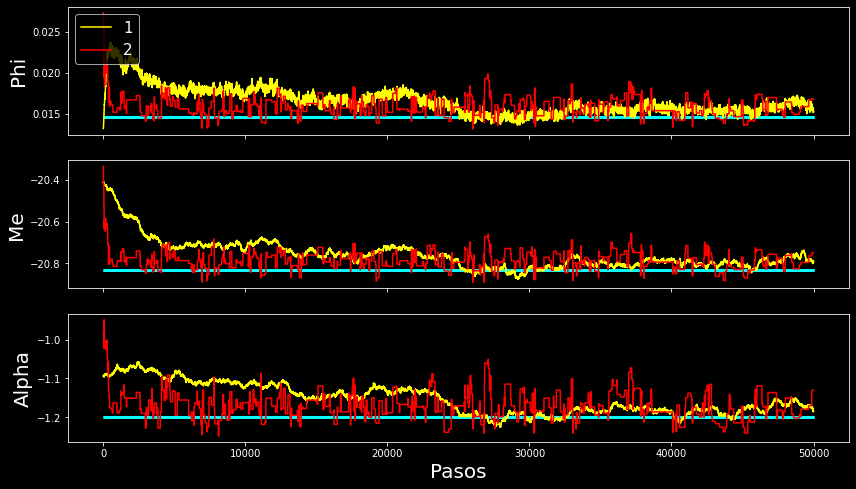

In [15]:
""" MAL MEZCLADO """ 
fig, ax = plt.subplots(3, 1, figsize = (14,8), sharex=True)
Ploteo(C4, color='yellow', label='1', fig=fig, ax=ax)
Ploteo(C5, color='red', label='2', fig=fig, ax=ax)
# Bordes de los priors
# ax[0].fill_between([Nburnt, Nsteps], y1=rPhi[0], y2=rPhi[1], facecolor='green', alpha=0.3)
# ax[1].fill_between([Nburnt, Nsteps], y1=rMe[0], y2=rMe[1], facecolor='green', alpha=0.3)
# ax[2].fill_between([Nburnt, Nsteps], y1=ralpha[0], y2=ralpha[1], facecolor='green', alpha=0.3)

La cadena amarilla tiene un paso muy chico y nunca llega al máximo del likelihood, la roja tiene un paso muy grande (comparada con las cadenas anteriores, pero no es tan malo)

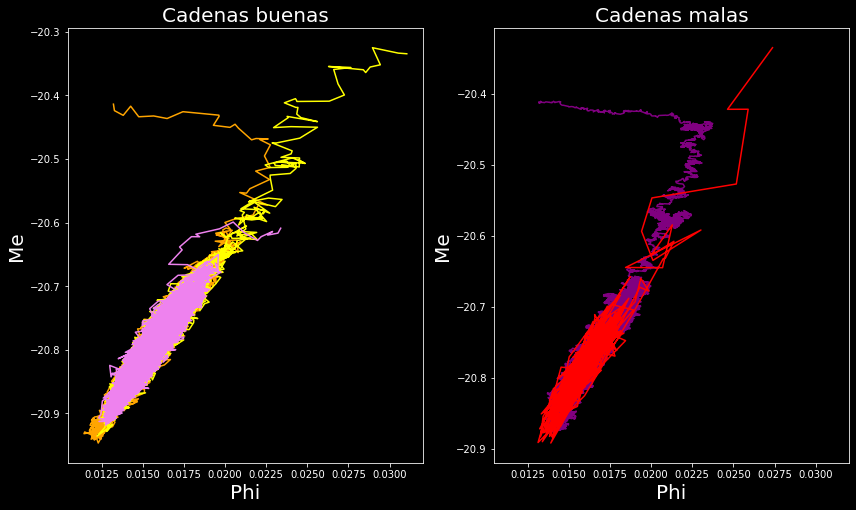

In [24]:
""" CAMINOS """
fig, ax = plt.subplots(1, 2, figsize = (14,8), sharex=True)

ax[0].plot(C[1], C[2], color='orange', label='1, buen mezclado')
ax[0].plot(C2[1], C2[2], color='yellow', label='2, buen mezclado')
ax[0].plot(C3[1], C3[2], color='violet', label='3, buen mezclado')
ax[1].plot(C4[1], C4[2], color='purple', label='4, mal mezclado')
ax[1].plot(C5[1], C5[2], color='red', label='5, mal mezclado');

ax[0].set_ylabel('Me', fontsize=20)
ax[0].set_xlabel('Phi', fontsize=20)
ax[1].set_ylabel('Me', fontsize=20)
ax[1].set_xlabel('Phi', fontsize=20)
ax[0].set_title('Cadenas buenas', fontsize=20)
ax[1].set_title('Cadenas malas', fontsize=20);

En la imagen anterior no hay mucha diferencia entre las cadenas "buenas" y "malas" (porque todo se superpone)

Notar que las cadenas "malas" empiezan en el mismo lugar que algunas de las "buenas". Eso fue intencional como para compararlas mejor entre si

Ahora hago un corner plot con el paquete de una de las cadenas buenas, para eso hago un quemado manual:

In [25]:
# Quemado manual:
B = [C[1][10000:], C[2][10000:], C[3][10000:]]
np.shape(B)
plt.style.use('classic')

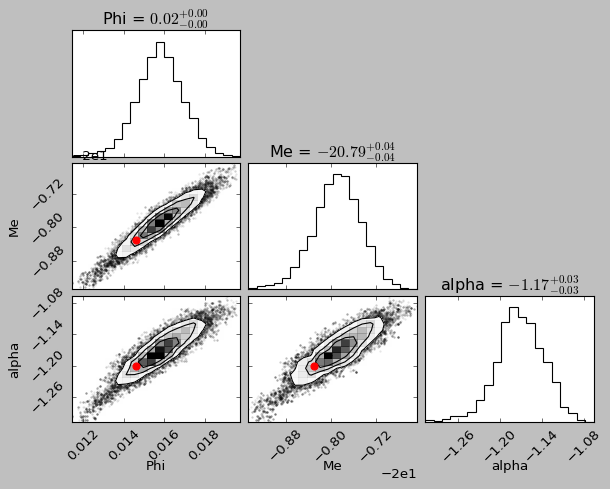

In [26]:
ndim = 3
# Corner plot de una cadena:
import corner
aa = np.transpose(B)
plt.style.use('classic')

fig, ax = plt.subplots(3, 3, figsize = (8,6))
labels = ['Phi', 'Me', 'alpha']
fig = corner.corner(aa, labels = labels, fig = fig, show_titles = True)

# Blanton
value1 = 0.0146
value2 = -20.83
value3 = -1.20

axes = np.array(fig.axes).reshape((ndim, ndim))
axes[1,0].scatter(value1, value2, zorder=5, color='red', s=40)
axes[2,0].scatter(value1, value3, zorder=5, color='red', s=40)
axes[2,1].scatter(value2, value3, zorder=5, color='red', s=40)

Los puntos rojos son los valores de Blanton

Se me complicó poner las regiones de confianza graficadas en las posteriors (líneas verticales), será para otra ocasión

Veo la obtención de incertezas:

In [27]:
# Obtención de errores, lo hago tal que el area en las colas sea del 10% (arbitrario)
# Eso implica que los cuantiles que buscaré son: el 5 y el 95
Param = np.empty(3)
ERR_DOWN = np.empty(3) # Arreglos para meter los valores
ERR_UP = np.empty(3)

ij=0
while ij<3: 
    # Rcordar que C3[0] : pasos (no es un parámetro)
    q_05, q_50, q_95 = corner.quantile(C[ij+1], [0.05, 0.5, 0.95]) 
    x = q_50 # Parametro ajustado
    dx_down, dx_up = q_50-q_05, q_95-q_50 # Errores
    Param[ij] = q_50
    ERR_DOWN[ij] = dx_down
    ERR_UP[ij] = dx_up
    ij = ij+1

In [24]:
Param, ERR_DOWN, ERR_UP

(array([ 1.57981361e-02, -2.07873425e+01, -1.17197872e+00]),
 array([0.0018483 , 0.07166332, 0.05358031]),
 array([0.00192603, 0.06795435, 0.05515229]))

In [32]:
Blanton = [0.0146, -20.83, -1.2]
if ERR_DOWN[0] < Blanton[0] and ERR_UP[0] < Blanton[0]:
    print('Phi es compatible con Blanton')
else:
    print('Phi NO es compatible con Blanton')

Phi es compatible con Blanton


In [30]:
if ERR_DOWN[1] < Blanton[1] and ERR_UP[1] < Blanton[1]:
    print('Me es compatible con Blanton')
else:
    print('Me NO es compatible con Blanton')

Me NO es compatible con Blanton


In [31]:
if ERR_DOWN[2] < Blanton[2] and ERR_UP[2] < Blanton[2]:
    print('alpha es compatible con Blanton')
else:
    print('alpha NO es compatible con Blanton')

alpha NO es compatible con Blanton


Hice este análisis muy simplificado de intervalos de confianza por el tiempo. Cualitativamente parecería como que el máximo no está justo en los valores que obtuvo Blanton

Grafico mi modelo contra el de Blanton

In [33]:
# Modelo Markov
xs = np.linspace(min(Mags), max(Mags), 100)
F_mod2 = Modelo(xs,C[1][-1], C[2][-1], C[3][-1])
plt.style.use('dark_background')

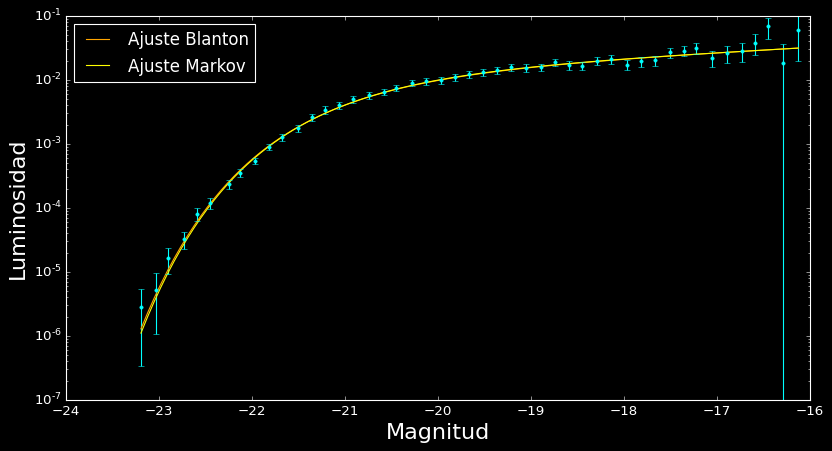

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (12,6), sharex=True)
plt.style.use('dark_background')
ax.plot(xs, F_mod, color='orange', label='Ajuste Blanton')
ax.plot(xs, F_mod2, color='yellow', label='Ajuste Markov')
ax.errorbar(Mags, Lum, yerr=ERR, color='cyan', fmt='.')

ax.set_xlabel('Magnitud', fontsize=20)
ax.set_ylabel('Luminosidad', fontsize=20)
ax.set_yscale('log')
ax.legend(fontsize=15, loc=2);

Prácticamente indistinguibles considerando las barras de error en esta figura